## Goal

Here we want to know the parameter range, including 

1. The distance between a pair of atoms
2. The maximum of Omega
3. The maximum of abs value of Delta
4. The slew rate of Omega, Delta, and phi

that the local simulator can give reasonable result. And we will investigate what to suggest to customers if they want to go out of the range. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

from braket.ahs.hamiltonian import Hamiltonian
from braket.ahs.atom_arrangement import AtomArrangement
from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation

from braket.timings.time_series import TimeSeries
from braket.ahs.driving_field import DrivingField

from braket.devices import LocalSimulator
device = LocalSimulator("braket_ahs")

from ahs_utils import show_global_drive

from pprint import pprint as pp

def get_counters_from_result(result):
    post_sequences = [list(measurement.post_sequence) for measurement in result.measurements]
    post_sequences = ["".join(['r' if site==0 else 'g' for site in post_sequence]) for post_sequence in post_sequences]

    counters = {}
    for post_sequence in post_sequences:
        if post_sequence in counters:
            counters[post_sequence] += 1
        else:
            counters[post_sequence] = 1
    return counters


In [2]:
num1 = 10 # number of data points for Omega

Delta_slew_range = np.linspace(10, 3000, num1) * 1e12 # The range of Omega


t_max = 4e-6 # We fix the duration of the program
C6 = 5.42e-24 # The interaction coefficient
shots = 10_000 # We fix the number of shots
steps = 100 # For time steps
nsteps = 1000 # For scipy
epsilon = 0.01 # threshold for the discrepancy of local sim and theory result

def Rb(Omega, Delta):
    return (C6/np.sqrt(Omega**2 + Delta**2))**(1/6)

In [3]:
def compare(programs, steps = steps, shots = shots, nsteps=nsteps):


    results_sim = {}
    results_theory = {}
    diff = {}

    for key, program in programs.items():
        
        try:
            result = device.run(program, steps = steps, shots = shots, nsteps=nsteps).result()
        except:
            print(f"Error for {key}")
            continue
        
        print(f"Result got for {key}")
        result_sim_temp = get_counters_from_result(result)
        
        results_sim[key] = {'g': 0, 'r': 0}
        
        
        num_atoms = int(len(list(result_sim_temp.keys())[0]))
                
        for key2, val2 in result_sim_temp.items():
            for i in range(num_atoms):
                results_sim[key][key2[i]] += val2

        # Get the theory result
        values = programs[key].hamiltonian.detuning.time_series.values()
        Delta_area = values[2] * t_max/2
        g_theory = round(np.cos(Delta_area/2)**2 * shots*num_atoms)
        r_theory = round(np.sin(Delta_area/2)**2 * shots*num_atoms)
# #         print(values)
#         Z = np.array([
#             [1, 0], 
#             [0, -1]])
#         U = scipy.linalg.expm(-1j * Delta_area/2 * Z)

#         g_theory = round(np.abs(U[0][0]+U[1][1])**2 * shots*num_atoms)
#         r_theory = round(np.abs(U[0][0]-U[1][1])**2 * shots*num_atoms)
        

        results_theory[key] = {
            'g': g_theory,
            'r': r_theory
        }

        diff[key] = {}

        
        for state in ['g', 'r']:
            diff[key][state] = abs(results_theory[key][state]-results_sim[key][state])/(shots*num_atoms)
            
    return results_sim, results_theory, diff

def visualize_diff(diff, state="g"):
    
    plt.plot(list(diff.keys()), [item[state]*100 for item in list(diff.values())], 'o-')
    plt.xlabel("Delta slew rate (Hz)")
    plt.ylabel("differece in percentage")    
    
    

## Task 3: Triangular pulses for a pair of atoms
This is for testing the robustness of the numpy solver

In [4]:
programs = {}
Omega = 15800000.0
t_Omega = np.pi/2/Omega
for Delta_slew in Delta_slew_range:
        
    register = AtomArrangement()
            
    register.add([0, 0])

    Omega_global = TimeSeries()
    Omega_global.put(0.0, Omega).put(t_Omega, Omega)
    
    # e.g. all-zero phase and detuning
    phi = TimeSeries().put(0.0, 0.0).put(t_Omega, 0.0)  # (time [s], value [rad])
    Delta_global = TimeSeries().put(0.0, 0.0).put(t_Omega, 0.0)
    
    
    Delta_global = Delta_global.put(t_Omega+t_max/2, Delta_slew * t_max/2).put(t_Omega+t_max, 0)  # (time [s], value [rad/s])
    Omega_global = Omega_global.put(t_Omega+t_max, 0)
    phi = phi.put(t_Omega+t_max, 0)

    drive = DrivingField(
        amplitude=Omega_global,
        phase=phi,
        detuning=Delta_global
    )            
    
    program = AnalogHamiltonianSimulation(
        hamiltonian=drive,
        register=register
    )

    programs[Delta_slew] = program


In [5]:
results_sim, results_theory, diff = compare(programs)

/Users/maolinml/opt/anaconda3/lib/python3.9/site-packages/braket/analog_hamiltonian_simulator/rydberg/validators/times_series.py:39: UserWarning: Max time is 0.000004099417489037652 seconds which is bigger than the typical scale (0.000004 seconds). The time points should  be specified in SI units.
  warnings.warn(


Result got for 10000000000000.0
Result got for 342222222222222.25


/Users/maolinml/opt/anaconda3/lib/python3.9/site-packages/braket/analog_hamiltonian_simulator/rydberg/validators/field_validator_util.py:22: UserWarning: Value 2 (684444444.4444444) in detuning time series outside the typical range [-125000000.0, 125000000.0]. The values should  be specified in SI units.
  warnings.warn(
/Users/maolinml/opt/anaconda3/lib/python3.9/site-packages/braket/analog_hamiltonian_simulator/rydberg/validators/field_validator_util.py:22: UserWarning: Value 2 (1348888888.8888888) in detuning time series outside the typical range [-125000000.0, 125000000.0]. The values should  be specified in SI units.
  warnings.warn(


Result got for 674444444444444.5
Result got for 1006666666666666.8


/Users/maolinml/opt/anaconda3/lib/python3.9/site-packages/braket/analog_hamiltonian_simulator/rydberg/validators/field_validator_util.py:22: UserWarning: Value 2 (2013333333.3333335) in detuning time series outside the typical range [-125000000.0, 125000000.0]. The values should  be specified in SI units.
  warnings.warn(
/Users/maolinml/opt/anaconda3/lib/python3.9/site-packages/braket/analog_hamiltonian_simulator/rydberg/validators/field_validator_util.py:22: UserWarning: Value 2 (2677777777.7777777) in detuning time series outside the typical range [-125000000.0, 125000000.0]. The values should  be specified in SI units.
  warnings.warn(


Result got for 1338888888888889.0


/Users/maolinml/opt/anaconda3/lib/python3.9/site-packages/braket/analog_hamiltonian_simulator/rydberg/validators/field_validator_util.py:22: UserWarning: Value 2 (3342222222.222222) in detuning time series outside the typical range [-125000000.0, 125000000.0]. The values should  be specified in SI units.
  warnings.warn(
/Users/maolinml/opt/anaconda3/lib/python3.9/site-packages/braket/analog_hamiltonian_simulator/rydberg/validators/field_validator_util.py:22: UserWarning: Value 2 (4006666666.666667) in detuning time series outside the typical range [-125000000.0, 125000000.0]. The values should  be specified in SI units.
  warnings.warn(


Result got for 1671111111111111.0
Result got for 2003333333333333.5


/Users/maolinml/opt/anaconda3/lib/python3.9/site-packages/braket/analog_hamiltonian_simulator/rydberg/validators/field_validator_util.py:22: UserWarning: Value 2 (4671111111.111111) in detuning time series outside the typical range [-125000000.0, 125000000.0]. The values should  be specified in SI units.
  warnings.warn(


Result got for 2335555555555555.5
Result got for 2667777777777778.0


/Users/maolinml/opt/anaconda3/lib/python3.9/site-packages/braket/analog_hamiltonian_simulator/rydberg/validators/field_validator_util.py:22: UserWarning: Value 2 (5335555555.555555) in detuning time series outside the typical range [-125000000.0, 125000000.0]. The values should  be specified in SI units.
  warnings.warn(


Result got for 3000000000000000.0


/Users/maolinml/opt/anaconda3/lib/python3.9/site-packages/braket/analog_hamiltonian_simulator/rydberg/validators/field_validator_util.py:22: UserWarning: Value 2 (6000000000.0) in detuning time series outside the typical range [-125000000.0, 125000000.0]. The values should  be specified in SI units.
  warnings.warn(


In [6]:
results_sim

{10000000000000.0: {'g': 6542, 'r': 3458},
 342222222222222.25: {'g': 1970, 'r': 8030},
 674444444444444.5: {'g': 1973, 'r': 8027},
 1006666666666666.8: {'g': 1881, 'r': 8119},
 1338888888888889.0: {'g': 2540, 'r': 7460},
 1671111111111111.0: {'g': 2170, 'r': 7830},
 2003333333333333.5: {'g': 2250, 'r': 7750},
 2335555555555555.5: {'g': 2650, 'r': 7350},
 2667777777777778.0: {'g': 2938, 'r': 7062},
 3000000000000000.0: {'g': 3201, 'r': 6799}}

In [7]:
results_theory

{10000000000000.0: {'g': 1665, 'r': 8335},
 342222222222222.25: {'g': 8317, 'r': 1683},
 674444444444444.5: {'g': 1701, 'r': 8299},
 1006666666666666.8: {'g': 8281, 'r': 1719},
 1338888888888889.0: {'g': 1738, 'r': 8262},
 1671111111111111.0: {'g': 8244, 'r': 1756},
 2003333333333333.5: {'g': 1774, 'r': 8226},
 2335555555555555.5: {'g': 8208, 'r': 1792},
 2667777777777778.0: {'g': 1811, 'r': 8189},
 3000000000000000.0: {'g': 8171, 'r': 1829}}

In [8]:
diff

{10000000000000.0: {'g': 0.4877, 'r': 0.4877},
 342222222222222.25: {'g': 0.6347, 'r': 0.6347},
 674444444444444.5: {'g': 0.0272, 'r': 0.0272},
 1006666666666666.8: {'g': 0.64, 'r': 0.64},
 1338888888888889.0: {'g': 0.0802, 'r': 0.0802},
 1671111111111111.0: {'g': 0.6074, 'r': 0.6074},
 2003333333333333.5: {'g': 0.0476, 'r': 0.0476},
 2335555555555555.5: {'g': 0.5558, 'r': 0.5558},
 2667777777777778.0: {'g': 0.1127, 'r': 0.1127},
 3000000000000000.0: {'g': 0.497, 'r': 0.497}}

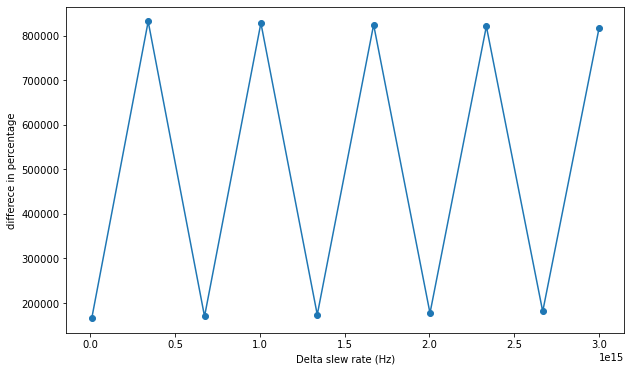

In [10]:
plt.rcParams["figure.figsize"] = (10,6)
visualize_diff(results_theory)

### Rerun with larger number of time steps

In [137]:
results_sim, results_theory, diff = compare(programs, steps = 100 * steps)

/Users/maolinml/opt/anaconda3/lib/python3.9/site-packages/braket/analog_hamiltonian_simulator/rydberg/validators/times_series.py:39: UserWarning: Max time is 0.000004099417489037652 seconds which is bigger than the typical scale (0.000004 seconds). The time points should  be specified in SI units.
  warnings.warn(


Result got for 10000000000000.0


/Users/maolinml/opt/anaconda3/lib/python3.9/site-packages/braket/analog_hamiltonian_simulator/rydberg/validators/field_validator_util.py:22: UserWarning: Value 2 (684444444.4444444) in detuning time series outside the typical range [-125000000.0, 125000000.0]. The values should  be specified in SI units.
  warnings.warn(


Result got for 342222222222222.25


/Users/maolinml/opt/anaconda3/lib/python3.9/site-packages/braket/analog_hamiltonian_simulator/rydberg/validators/field_validator_util.py:22: UserWarning: Value 2 (1348888888.8888888) in detuning time series outside the typical range [-125000000.0, 125000000.0]. The values should  be specified in SI units.
  warnings.warn(


Result got for 674444444444444.5


/Users/maolinml/opt/anaconda3/lib/python3.9/site-packages/braket/analog_hamiltonian_simulator/rydberg/validators/field_validator_util.py:22: UserWarning: Value 2 (2013333333.3333335) in detuning time series outside the typical range [-125000000.0, 125000000.0]. The values should  be specified in SI units.
  warnings.warn(


Result got for 1006666666666666.8


/Users/maolinml/opt/anaconda3/lib/python3.9/site-packages/braket/analog_hamiltonian_simulator/rydberg/validators/field_validator_util.py:22: UserWarning: Value 2 (2677777777.7777777) in detuning time series outside the typical range [-125000000.0, 125000000.0]. The values should  be specified in SI units.
  warnings.warn(


Result got for 1338888888888889.0


/Users/maolinml/opt/anaconda3/lib/python3.9/site-packages/braket/analog_hamiltonian_simulator/rydberg/validators/field_validator_util.py:22: UserWarning: Value 2 (3342222222.222222) in detuning time series outside the typical range [-125000000.0, 125000000.0]. The values should  be specified in SI units.
  warnings.warn(


Result got for 1671111111111111.0


/Users/maolinml/opt/anaconda3/lib/python3.9/site-packages/braket/analog_hamiltonian_simulator/rydberg/validators/field_validator_util.py:22: UserWarning: Value 2 (4006666666.666667) in detuning time series outside the typical range [-125000000.0, 125000000.0]. The values should  be specified in SI units.
  warnings.warn(


Result got for 2003333333333333.5


/Users/maolinml/opt/anaconda3/lib/python3.9/site-packages/braket/analog_hamiltonian_simulator/rydberg/validators/field_validator_util.py:22: UserWarning: Value 2 (4671111111.111111) in detuning time series outside the typical range [-125000000.0, 125000000.0]. The values should  be specified in SI units.
  warnings.warn(


Result got for 2335555555555555.5


/Users/maolinml/opt/anaconda3/lib/python3.9/site-packages/braket/analog_hamiltonian_simulator/rydberg/validators/field_validator_util.py:22: UserWarning: Value 2 (5335555555.555555) in detuning time series outside the typical range [-125000000.0, 125000000.0]. The values should  be specified in SI units.
  warnings.warn(


Result got for 2667777777777778.0


/Users/maolinml/opt/anaconda3/lib/python3.9/site-packages/braket/analog_hamiltonian_simulator/rydberg/validators/field_validator_util.py:22: UserWarning: Value 2 (6000000000.0) in detuning time series outside the typical range [-125000000.0, 125000000.0]. The values should  be specified in SI units.
  warnings.warn(


Result got for 3000000000000000.0


In [146]:
results_sim

{10000000000000.0: {'g': 6489, 'r': 3511},
 342222222222222.25: {'g': 2409, 'r': 7591},
 674444444444444.5: {'g': 2748, 'r': 7252},
 1006666666666666.8: {'g': 3072, 'r': 6928},
 1338888888888889.0: {'g': 3195, 'r': 6805},
 1671111111111111.0: {'g': 3380, 'r': 6620},
 2003333333333333.5: {'g': 3507, 'r': 6493},
 2335555555555555.5: {'g': 3639, 'r': 6361},
 2667777777777778.0: {'g': 3711, 'r': 6289},
 3000000000000000.0: {'g': 3748, 'r': 6252}}

In [147]:
results_theory

{10000000000000.0: {'g': 8335, 'r': 1665},
 342222222222222.25: {'g': 1683, 'r': 8317},
 674444444444444.5: {'g': 8299, 'r': 1701},
 1006666666666666.8: {'g': 1719, 'r': 8281},
 1338888888888889.0: {'g': 8262, 'r': 1738},
 1671111111111111.0: {'g': 1756, 'r': 8244},
 2003333333333333.5: {'g': 8226, 'r': 1774},
 2335555555555555.5: {'g': 1792, 'r': 8208},
 2667777777777778.0: {'g': 8189, 'r': 1811},
 3000000000000000.0: {'g': 1829, 'r': 8171}}

In [144]:
pp(diff)

{10000000000000.0: {'g': 0.1846, 'r': 0.1846},
 342222222222222.25: {'g': 0.0726, 'r': 0.0726},
 674444444444444.5: {'g': 0.5551, 'r': 0.5551},
 1006666666666666.8: {'g': 0.1353, 'r': 0.1353},
 1338888888888889.0: {'g': 0.5067, 'r': 0.5067},
 1671111111111111.0: {'g': 0.1624, 'r': 0.1624},
 2003333333333333.5: {'g': 0.4719, 'r': 0.4719},
 2335555555555555.5: {'g': 0.1847, 'r': 0.1847},
 2667777777777778.0: {'g': 0.4478, 'r': 0.4478},
 3000000000000000.0: {'g': 0.1919, 'r': 0.1919}}


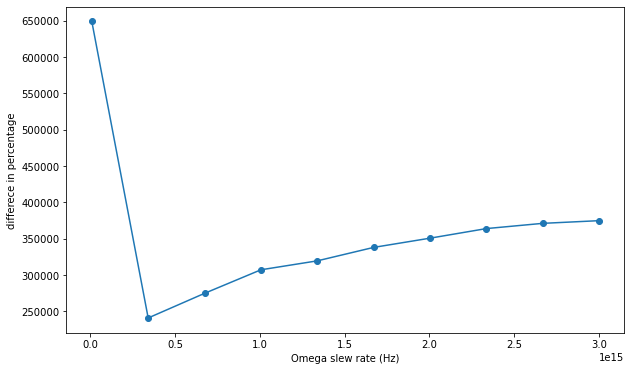

In [145]:
plt.rcParams["figure.figsize"] = (10,6)
visualize_diff(results_sim)

### Rerun with larger number of shots

In [64]:
results_sim, results_theory, diff = compare(programs, shots = 10 * shots)

Result got for 10000000000000.0
Result got for 42222222222222.22
Result got for 74444444444444.44
Result got for 106666666666666.66
Result got for 138888888888888.89
Result got for 171111111111111.12
Result got for 203333333333333.3
Result got for 235555555555555.53
Result got for 267777777777777.78
Result got for 300000000000000.0


In [65]:
pp(diff)

{10000000000000.0: {'g': 2e-05, 'r': 2e-05},
 42222222222222.22: {'g': 0.00829, 'r': 0.00829},
 74444444444444.44: {'g': 0.17, 'r': 0.17},
 106666666666666.66: {'g': 0.63558, 'r': 0.63558},
 138888888888888.89: {'g': 0.89462, 'r': 0.89462},
 171111111111111.12: {'g': 0.11756, 'r': 0.11756},
 203333333333333.3: {'g': 0.01617, 'r': 0.01617},
 235555555555555.53: {'g': 0.40692, 'r': 0.40692},
 267777777777777.78: {'g': 0.61729, 'r': 0.61729},
 300000000000000.0: {'g': 0.43753, 'r': 0.43753}}


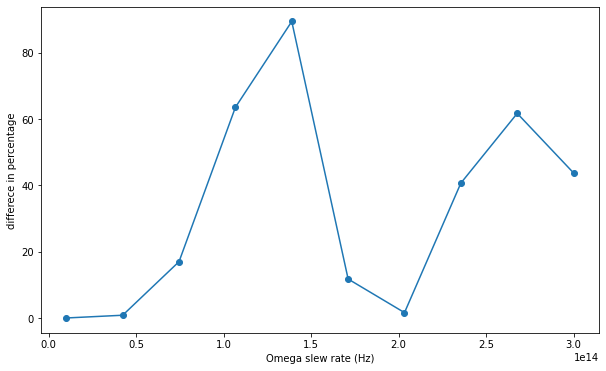

In [66]:
plt.rcParams["figure.figsize"] = (10,6)
visualize_diff(diff)

## Conclusion
